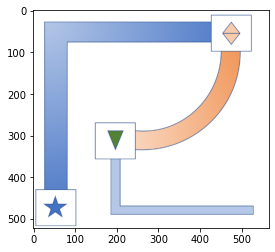

In [50]:
import cv2
import numpy as np
import math

from matplotlib import pyplot as plt
def imshow(img): #functionแสดงรูปจะได้ไม่ต้องพิมพ์บ่อยๆ 
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #matplotlibเป็นระบบBGRต้องแปลงให้เป็นRGBก่อน
    plt.show()

frame = cv2.imread("m.png") #อ่านรูปm.png
imshow(frame) #showรูป
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

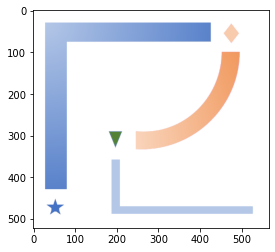

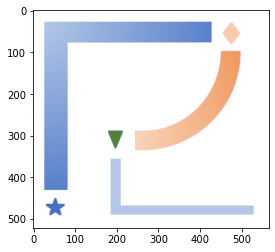

In [51]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(frame,kernel,iterations = 1)
erosion = cv2.erode(dilation,kernel,iterations = 1)
imshow(dilation)
imshow(erosion)

3.0


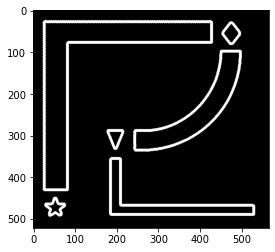

In [52]:
edges = cv2.Canny(erosion, 20, 100)

contours, hierarchy = cv2.findContours(edges,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
black = np.zeros(frame.shape[:2], dtype="uint8") #For visualize card border
print (len(contours)/2)
for i in range(len(contours)): #Draw each contours
      cv2.drawContours(black, contours, i, 255, 6)
imshow(black)

In [53]:
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02*peri, True)
    rect = np.asarray(approx, dtype = "float32")
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    center = (cX, cY)
    
    print(center)

(52, 472)
(314, 460)
(196, 303)
(389, 238)
(474, 55)
(140, 152)


In [54]:
erosion = cv2.erode(frame,kernel,iterations = 1)
edges = cv2.Canny(frame, 20, 100)

contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
black = np.zeros(frame.shape[:2], dtype="uint8") #For visualize card border
print (len(contours))
# for i in range(len(contours)): #Draw each contours
#     black = np.zeros(frame.shape[:2], dtype="uint8") #For visualize card border
#     cv2.drawContours(black, contours, i, 255, 6)
#     print(len(contours[i]))
# imshow(black)

88


1.1176470588235294
[[[427  13]]

 [[427  97]]

 [[521  97]]

 [[521  13]]]


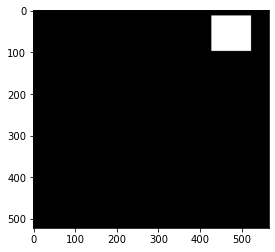

1.1176470588235294
[[[427  14]]

 [[520  13]]

 [[521  96]]

 [[428  97]]]


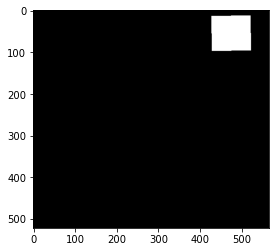

1.1176470588235294
[[[  7 432]]

 [[100 431]]

 [[101 514]]

 [[  8 515]]]


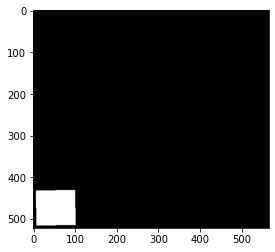

0.7125
1.7239819004524888
1.1176470588235294
[[[150 271]]

 [[150 355]]

 [[244 354]]

 [[243 271]]]


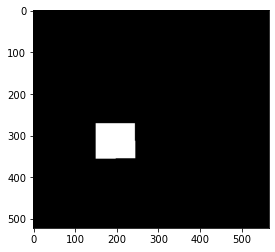

1.1176470588235294
[[[150 272]]

 [[243 271]]

 [[244 354]]

 [[151 355]]]


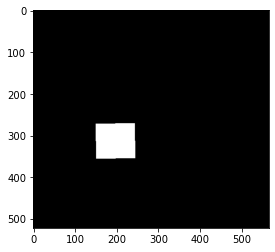

In [55]:
Approx = []
for i in range(len(contours)): #Draw each contours
    black = np.zeros(frame.shape[:2], dtype="uint8") #For visualize card border
    epsilon = 0.1*cv2.arcLength(contours[i],True)
    approx = cv2.approxPolyDP(contours[i],epsilon,True)
#     print(len(approx))
    if len(approx) != 4: continue
    if cv2.contourArea(approx) < 5000: continue
    if cv2.contourArea(approx) > 9000: continue
    (x, y, w, h) = cv2.boundingRect(approx)
    ar = w / float(h)
    print(ar)
    R = 0.15
    if ar >= 1-R and ar <= 1+R:  pass
    else: continue
    print(approx)
    cv2.drawContours(black, [approx], 0, 255, -1)
    imshow(black)
    Approx.append(approx)
    

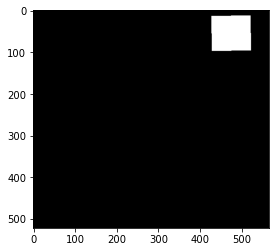

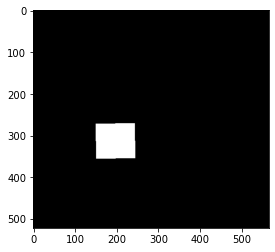

In [56]:
black = np.zeros(frame.shape[:2], dtype="uint8") #For visualize card border
A = []

def findContourCenter(c):
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cX, cY)
    
for a in Approx:
    #คัดเลือกคอนทัวที่ไม่ซ้ำไว้ในอาเรA
    mask_a = cv2.drawContours(black.copy(), [a], 0, 255, -1)
    unique = True
    
    for b in A:
        mask_b = cv2.drawContours(black.copy(), [b], 0, 255, -1)
        des = cv2.bitwise_and(mask_a,mask_a,mask = mask_b)

        if cv2.pointPolygonTest(b, findContourCenter(a), False) != -1:
            unique = False
            imshow(des)

           
    if unique:
        A.append(a)
    
        

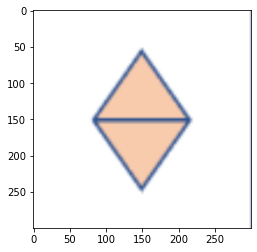

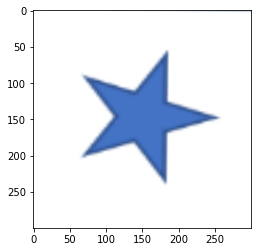

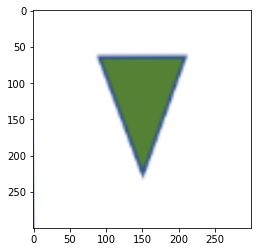

In [57]:
#หาฐานสี่เหลี่ยมเสร็จแล้ว ต่อไปหาจุดmarkerของรูปต่างๆ ใช้perspective transform
for pts1 in A:
    pts1 = np.float32([pts1[3][0] ,pts1[0][0], pts1[2][0], pts1[1][0]])
    pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(frame,M,(300,300))
    
    imshow(dst)
#หา path ใช้skeleton

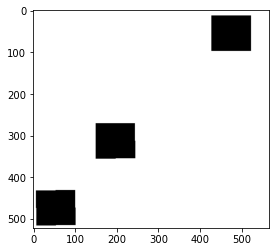

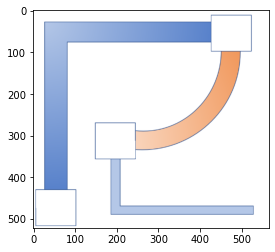

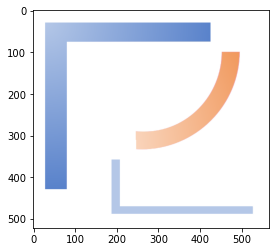

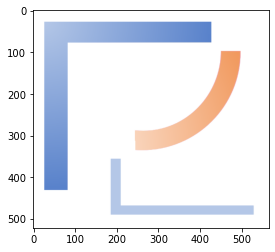

In [58]:
#เอารูปที่ลบป้ายสัญลักษณ์มาแล้วทำskeleton
#นำmaskมาandกับภาพต้นฉบับ

# Draw the contours on the mask

canva = np.ones(frame.shape[:2], dtype='uint8') * 255
white = np.ones(frame.shape[:3], dtype='uint8') * 255
for marker_contour in A:
    cv2.drawContours(canva, [marker_contour], 0, 0, -1)
imshow(canva)

dest_or = cv2.bitwise_or(frame, frame, mask = canva)
mask = cv2.bitwise_not(canva)
bk = cv2.bitwise_or(white, white, mask=mask)
path_color = cv2.bitwise_or(dest_or, bk)
imshow(path_color)

dilation = cv2.dilate(path_color,kernel,iterations = 1)
erosion = cv2.erode(dilation,kernel,iterations = 1)
imshow(dilation)
imshow(erosion)

#################################################################


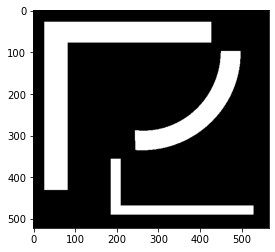

In [59]:
from skimage import img_as_bool, io, color, morphology
import matplotlib.pyplot as plt

erosion = cv2.cvtColor(erosion.copy(),cv2.COLOR_BGR2GRAY)

#Threshold the image with threshold value 220
ret, thresh = cv2.threshold(erosion.copy(),230,255,cv2.THRESH_BINARY_INV)
imshow(thresh)
thresh = thresh/255

out = morphology.skeletonize(thresh)

# f, (ax0, ax1) = plt.subplots(1, 2)
# ax0.imshow(erosion.copy(), cmap='gray', interpolation='nearest')
# ax1.imshow(out, cmap='gray', interpolation='nearest')
# plt.show()
# plt.imshow(out)
# plt.show()

    # import matplotlib.pyplot as plt
# from skimage.io import imread
# from skimage.filters import threshold_otsu
# from skimage.color import rgb2gray
# from skimage.morphology import skeletonize, binary_closing

# def get_binary(img):    
#     thresh = threshold_otsu(img)
#     binary = img > thresh
#     return binary

# im = get_binary(rgb2gray(erosion))
# out = binary_closing(skeletonize(im))

# f, (ax0, ax1) = plt.subplots(1, 2)
# ax0.imshow(im, cmap='gray', interpolation='nearest')
# ax1.imshow(out, cmap='gray', interpolation='nearest')
# plt.show()

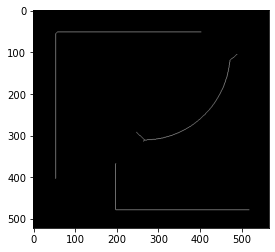

[197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197,

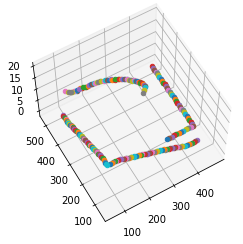

In [60]:
#ทำcontourแล้วเอาพิกัดxyไปเทียบกับภาพต้นฉบับจะได้ตำแหน่งสีนั้นๆออกมา

indices = out.astype(np.uint8)  #To convert the true to 1 and false to 0
indices*=255                   #To change all the 1's to 255
imshow(indices)

contour,_ = cv2.findContours(indices,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# print(len(contour))
# canva2 = np.zeros(frame.shape[:2], dtype="uint8")
# for i in range(len(contour)): canva2 = cv2.drawContours(canva2,contour,-1,255,2)
# imshow(canva2)

max_height = 20 #cm
min_height = 10 #cm

Z = []

path_points = []
path_heights = []
for c in contour:
    points = []
    heights = []
    for p in c:
        points.append((p[0][1], p[0][0]))
        heights.append(gray[p[0][1]][ p[0][0]])
    print(heights)
#     cv2.imshow("AAA", cv2.drawContours(gray, c, -1, 100))
#     cv2.waitKey(0)
    #cv2.imshow("AAA",gray)
    path_points.append(points)
    path_heights.append(heights)
    height_range = max_height - min_height
    hist, bins = np.histogram(heights, 256, [0, 256])
    cdf = hist.cumsum()
#     print(cdf)
    sorted_heights = sorted(heights)
    cdf_max = cdf[-1]
    cdf_thresh_min = int(cdf_max*0.10)
    cdf_thresh_max = int(cdf_max*0.90)
    print(len(heights), cdf_thresh_max)
    height_thresh_min = sorted_heights[cdf_thresh_min]
    height_thresh_max = sorted_heights[cdf_thresh_max]
    height_thresh_range = height_thresh_max - height_thresh_min
#     print("a")
#     print(height_range)

    if height_thresh_range < 25: ##change parameter eang
        Zs = [-1 for i in range (len(points))]
        print("AAA")
    else:
        Zs = []
        for h in heights:
            if h <= height_thresh_min: Zs.append(min_height)
            elif h>= height_thresh_max: Zs.append(max_height)
            else: Zs.append((h - height_thresh_min) * height_range / height_thresh_range + min_height)
    Z.append(Zs)
#     print(Zs)
# Zs = []
# for h in heights:
#     if h <= height_thresh_min: Zs.append(min_height)
#     elif h>= height_thresh_max: Zs.append(max_height)
#     else: Zs.append((h - height_thresh_min) * height_range / height_thresh_range + min_height)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in range(len(path_points)):
    points = path_points[j]
    for i in range(len(points)):
        if i%10 == 0:
            ax.scatter(points[i][0], points[i][1], Z[j][i])
#             z = gray[points[i][0]][points[i][1]]
#             print(z)
ax.view_init(azim=-120, elev=60)
plt.show()


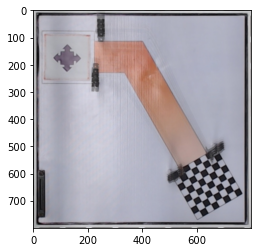

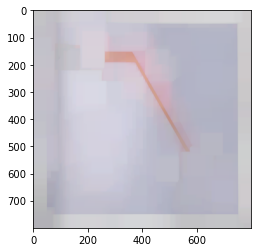

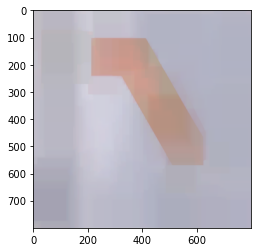

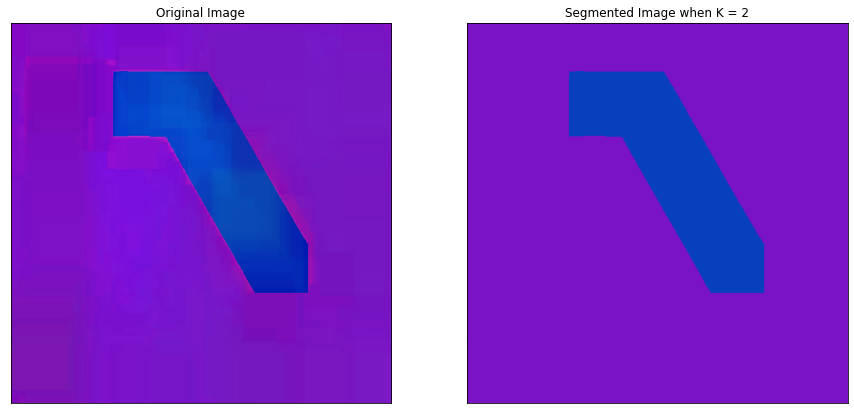

In [61]:
# Convert BGR to HSV
# frame3 = cv2.imread("Real5.png")
frame3 = cv2.imread("Realx.jpg")
gray = cv2.cvtColor(frame3, cv2.COLOR_BGR2GRAY)
gray_original = gray.copy()
dilation = cv2.dilate(frame3,kernel,iterations = 20)
erosion = cv2.erode(dilation,kernel,iterations = 25)
# canny = cv2.Canny(erosion, 20, 100)

# contour, aaa = cv2.findContours(canny,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# b = np.zeros(frame.shape[:2], dtype="uint8") #For visualize card border
# print (len(contours)/2)
# for i in range(len(contours)): #Draw each contours
#       cv2.drawContours(b, contour, i, 255, 6)
# imshow(black)

# hsv = cv2.cvtColor(canny, cv2.COLOR_BGR2HSV)
# mask3 = cv2.inRange(hsv,(0, 56, 82), (180, 255, 255) )

# Bitwise-AND mask and original image
#res = cv2.bitwise_and(frame3,frame3, mask= mask3)
imshow(frame3)
imshow(dilation)
imshow(erosion)
# imshow(canny)

K = 2
attempts=10

# img = cv2.imread("Real5.png")
img=cv2.cvtColor(erosion,cv2.COLOR_BGR2HSV)

vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS) #  cv.KMEANS_PP_CENTERS and cv.KMEANS_RANDOM_CENTERS.
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

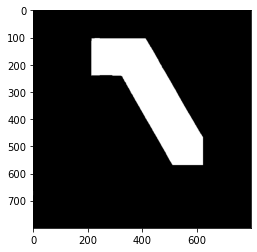

2
area
0.0
area
84421.5


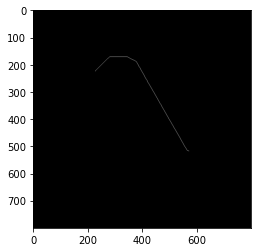

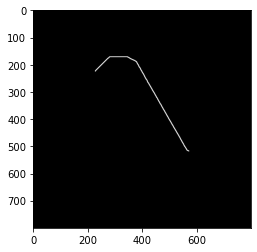

In [62]:
rgb = cv2.cvtColor(result_image, cv2.COLOR_HSV2RGB)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

ret, thresh = cv2.threshold(gray,170,255,cv2.THRESH_BINARY_INV)
imshow(thresh)

contour,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contour))
thresh_new = np.zeros_like(gray)
for c in contour:
    area = cv2.contourArea(c)
    print("area")
    print(area)

    if area > 200:
        cv2.drawContours(thresh_new, [c], -1, 255, -1)

thresh = thresh_new/255

out = morphology.skeletonize(thresh)                          

# opening = cv2.morphologyEx(out, cv2.MORPH_OPEN, (5,5))

#ทำcontourแล้วเอาพิกัดxyไปเทียบกับภาพต้นฉบับจะได้ตำแหน่งสีนั้นๆออกมา

indices2 = out.astype(np.uint8)  #To convert the true to 1 and false to 0
indices2*=255                   #To change all the 1's to 255
imshow(indices2)

contour,_ = cv2.findContours(indices2,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


canva3 = np.zeros(frame3.shape[:2], dtype="uint8")
for i in range(len(contour)): canva3 = cv2.drawContours(canva3,contour,-1,255,2)
imshow(canva3)

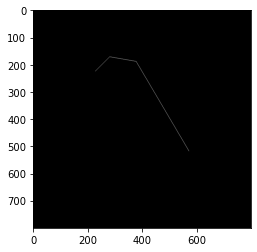

485 436
[20, 12.962962962962962, 15.185185185185185, 10.37037037037037]
[(228, 224, 20), (281, 171, 12.962962962962962), (378, 188, 15.185185185185185), (572, 517, 10.37037037037037)]


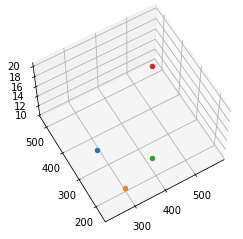

In [74]:
points_skeleton = np.column_stack(np.where(out.transpose() != 0) )# get array of points
poly_points = cv2.approxPolyDP(points_skeleton, 0.02 * frame3.shape[0], False) # approximate polygon

canva2 = np.zeros(frame3.shape[:2], dtype="uint8")
canva2 = cv2.polylines(canva2,[poly_points],False,(255,255,255),1)
imshow(canva2)
   

max_height = 20 #cm
min_height = 10 #cm

Z = []

points = []
intensities = []
heights = []

path_points = []
path_heights = []

for point in points_skeleton:
    path_points.append((point[0],point[1]))
    intensities.append(gray_original[point[1]][point[0]])

sorted_intensities = sorted(intensities)
height_range = max_height - min_height
hist, bins = np.histogram(intensities, 256, [0, 256])
cdf = hist.cumsum()



cdf_max = cdf[-1]
cdf_thresh_min = int(cdf_max*0.10)
cdf_thresh_max = int(cdf_max*0.90)
print(len(intensities), cdf_thresh_max)
height_thresh_min = sorted_intensities[cdf_thresh_min]
height_thresh_max = sorted_intensities[cdf_thresh_max]
height_thresh_range = height_thresh_max - height_thresh_min


if height_thresh_range < 25: ##change parameter eang
    Z = [-1 for i in range (len(points))]
else:
    Z = []
    for intensity in intensities:
        if intensity <= height_thresh_min: Z.append(min_height)
        elif intensity >= height_thresh_max: Z.append(max_height)
        else: Z.append((intensity - height_thresh_min) * height_range / height_thresh_range + min_height)

for p in poly_points:
    best = Z[0]
    cost = math.sqrt((p[0][0]-path_points[0][0])**2 + (p[0][1]-path_points[0][1])**2)
    for i, point in enumerate(path_points):
        new_cost = math.sqrt((p[0][0]-point[0])**2 + (p[0][1]-point[1])**2)
        if new_cost < cost:
            cost = new_cost
            best =  Z[i]
    heights.append(best)
    points.append((p[0][0], p[0][1],best)
print(heights)

print(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(points)): ax.scatter(points[i][0], points[i][1], points[i][2])
ax.view_init(azim=-120, elev=60)
plt.show()

134.5


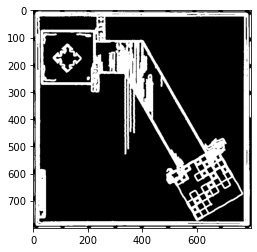

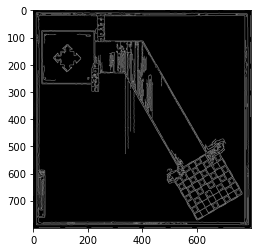

In [15]:
edges_new = cv2.Canny(frame3, 20, 100)

contours2, hierarchy = cv2.findContours(edges_new,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
black2 = np.zeros(frame3.shape[:2], dtype="uint8") #For visualize card border
print (len(contours2)/2) 
for i in range(len(contours2)): #Draw each contours
      cv2.drawContours(black2, contours2, i, 255, 6)
imshow(black2)
imshow(edges_new)